In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import KFold   # for CV using k-fold (k divisions of data)
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Linear Regression with regularization

In [2]:
def fit_linear_with_regularization(X, y, alpha):
    X_b = np.hstack([np.ones((X.shape[0], 1)), X])
    w_star = np.linalg.inv(X_b.T.dot(X_b) + alpha * np.eye(X_b.shape[1])).dot(X_b.T).dot(y) #normal regularization to find the optimal weights
    return w_star

def predict(X_test, w):
    X_test_b = np.hstack([np.ones((X_test.shape[0], 1)), X_test])  # Add a column of ones to X_test for the bias term
    y_pred = X_test_b.dot(w)
    return y_pred

def plot_prediction(X_test, y_test, y_pred):
    plt.scatter(X_test[:, 0], y_test, color='black', label='Actual Values')   # Scatter plot the first feature of X_test (x-axis) and the actual targets y_test (y-axis)
    plt.scatter(X_test[:, 0], y_pred, color='blue', label='Predictions')    #  predicted targets- y_pred using the first feature of X_test as x-axis

    # Compute the mean squared error
    mean_squared_error = np.mean((y_test - y_pred) ** 2)
    return mean_squared_error

    plt.xlabel('First feature of X_test')
    plt.ylabel('Diabetes progression')
    plt.title('Predictions vs Actual Values')
    plt.legend()


def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def cross_validate(X, y, alpha, num_folds=5):
    kf = KFold(n_splits=num_folds)
    mse_scores = []
    r2_scores = []
    i =1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        w = fit_linear_with_regularization(X_train, y_train, alpha)
        y_pred = predict(X_test, w)
        mse = np.mean((y_test - y_pred) ** 2)
        r2 = r_squared(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f'R-squared from CV_{i}:', r2.round(2))
        i+=1
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    return avg_mse, avg_r2

## Diabetes data

In [3]:
# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)

Mean Squared error is  1852.52


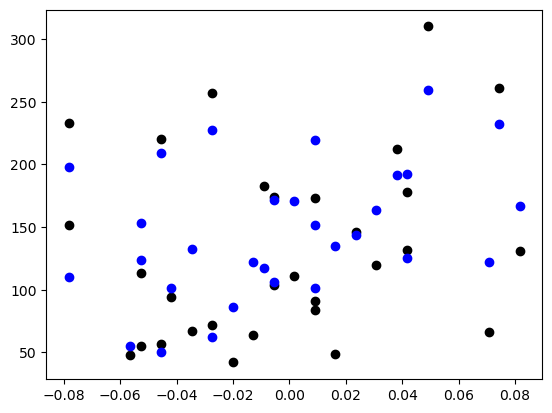

In [4]:
# Split the dataset into training and test set
num_test_elements = 30

X_train = X[:-num_test_elements]
X_test = X[-num_test_elements:]
y_train = y[:-num_test_elements]
y_test = y[-num_test_elements:]

# Set alpha- regularization strength
alpha = 0.01

# Train using linear regression with regularization and find optimal model
w = fit_linear_with_regularization(X_train, y_train, alpha)

# Make predictions using the testing set X_test
y_pred = predict(X_test, w)

# Plot and mean squared error
error = plot_prediction(X_test, y_test, y_pred).round(2)
print('Mean Squared error is ', error)
plt.show()

In [5]:
# k(5)-fold cross-validation
avg_mse, avg_r2 = cross_validate(X, y, alpha, num_folds=5)
print('Average MSE from CV:', avg_mse.round(2))
print('Average R-squared from CV:', avg_r2.round(2))

R-squared from CV_1: 0.42
R-squared from CV_2: 0.52
R-squared from CV_3: 0.49
R-squared from CV_4: 0.43
R-squared from CV_5: 0.55
Average MSE from CV: 2997.7
Average R-squared from CV: 0.48


-----------------------------------------------------------------------------------------------------------------------------------------------------------

# Classification algorithms

In [6]:
# Randomly generate data from two different distributions
data_class1, _ = make_gaussian_quantiles(mean = [1,1], cov = 1.5, n_samples = 30, n_features=2, random_state=18)
data_class2, _ = make_gaussian_quantiles(mean = [-1,-1], cov= 0.75,n_samples = 8, n_features=2, random_state=4)

# Concatenate the data, and add labels
X_train = np.append(data_class1, data_class2, axis=0)
y_train = np.append(np.zeros(len(data_class1), dtype=np.int32),
                   np.ones(len(data_class2), dtype=np.int32))

# Consider new test point
X_test = np.array([[-0.6,-0.4]])

def plot_data(X_train, y_train, X_test, title = ''):
    # Plot the two data classes
    fig,ax = plt.subplots(figsize=(10,10))
    ax.plot(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], 'o', markersize=8)
    ax.plot(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], 's', markersize=8)

    # Plot test point (circles to help with distances)
    ax.plot(X_test[:,0], X_test[:,1], '*', markersize=10)

    plt.axis('square')
    ax.legend(['Class 0','Class 1','test point'])
    ax.grid()
    ax.set_title(title, fontsize=15);
    return fig, ax

def decision_boundary(model, fig, ax, levels = [0.1,0.5,0.9], labels = True):
    # Code for producing the plot
    X1 = np.linspace(*ax.get_xlim(),100)
    X2 = np.linspace(*ax.get_ylim(), 100)
    Z = np.zeros(X1.shape+X2.shape)

    for i,x1 in enumerate(X1):
        for j,x2 in enumerate(X2):
            _, y_prob = model.predict(np.array([x1,x2]).reshape(1,-1))
            Z[j,i] = y_prob[0,0]

    contours = ax.contour(X1,X2,Z, levels=levels)
    if labels: ax.clabel(contours, inline=1, fontsize=10)
    return fig, ax

## K-Nearest-Neighbour Classification

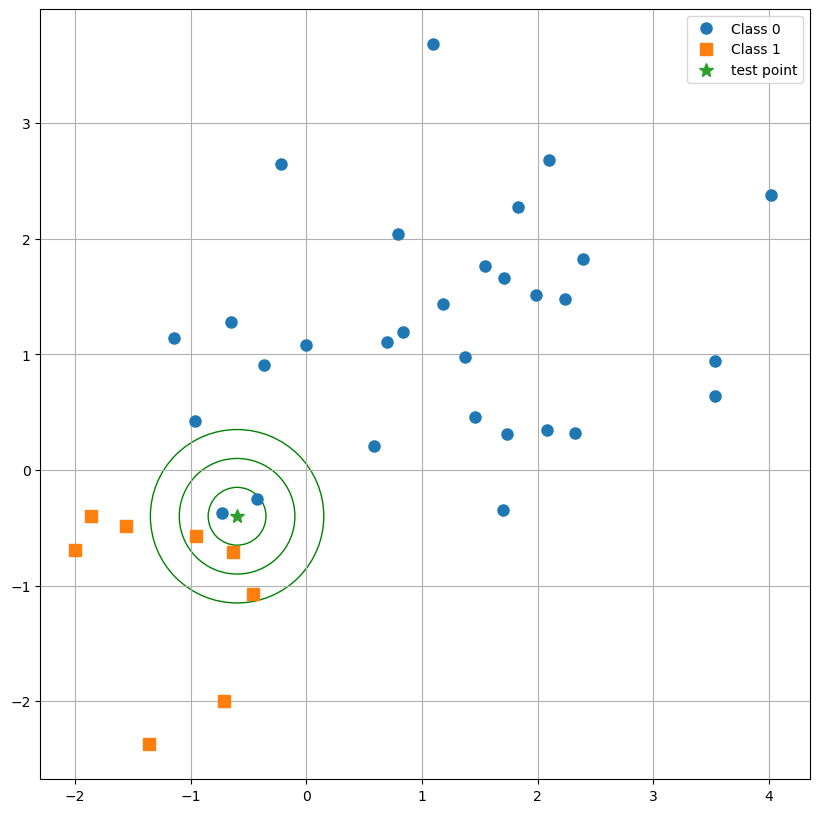

In [7]:
fig, ax = plot_data(X_train, y_train, X_test)

# Circles added to help visualize distance to points.
for r in np.arange(0.25,1,0.25):
    c = plt.Circle(X_test[0], r, color='g', fill=False)
    ax.add_artist(c)

In [8]:
class K_Nearest_Neighbors():
    """
    Custom implementation of K-nearest-neighbors.

    Note: If two or more classes have the same amount of neighbors, the prediction
    will be random, i.e. tiebreaks are resolved randomly.
    """

    def __init__(self, n_neighbors):
        """
        Parameter(s):
            n_neighbors - Number of neighbors
        """
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train):
        """
        No training required. Store data and labels.
        --------------------
        Input(s):
            X_train   - Data of size (n_samples, n_features)
            y_train   - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """
        Prediction of test data.
        --------------------
        Input(s):
            X_test   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels of size (n_samples,)
            y_pred_prob - Probabilistic labels of size (n_samples,n_classes)
        """

        n_samples = X_test.shape[0]
        unique_classes = np.unique(self.y_train)
        n_classes = len(unique_classes)
        y_pred = np.zeros(shape=(n_samples,), dtype=np.int32)
        y_pred_prob = np.zeros(shape=(n_samples, n_classes), dtype=np.float32)

        # Computes distances between all points in X_test and X_train.
        dist = euclidean_distances(X_test,self.X_train)

        for i in range(n_samples):
            dist_i = dist[i]

            ### TODO - Change this part
            arr, ind = np.unique(dist_i, return_index=True)
            ind1 = ind[:self.n_neighbors]
            labellst = []
            for k in ind1:
              labellst.append(self.y_train[k])
              #np.append(labelArr, self.y_train[k])

            labelArr = np.array(labellst)
            zeros = (labelArr == 0).sum()   # SUM CHECK
            ones = (labelArr == 1).sum()

            if(zeros>ones):
              y_pred_prob[i,:] = [1,0]
            elif(ones>zeros):
              y_pred_prob[i,:] = [0,1]
            else:
              y_pred_prob[i,:] = [0.5,0.5]

            # Selects the prediction randomly, based on y_pred_prob[i].
            y_pred[i] = np.random.choice(unique_classes, p=y_pred_prob[i])

        return y_pred, y_pred_prob

Train accuracy: 100.000 %
Predicted test class, K=3: 0


C:\Users\omkarp\AppData\Local\Temp\ipykernel_5948\1973260006.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted test class, K=%d: %d" %(K, y_pred_test))


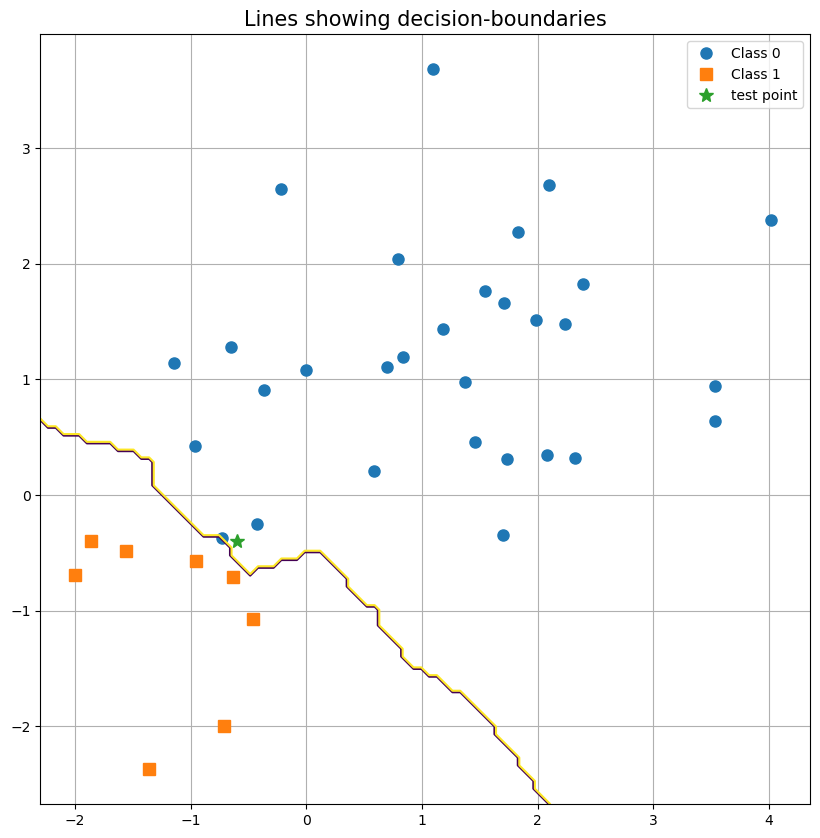

In [9]:
# Parameters (feel free to change)
K = 3

# Define and train the model
model = K_Nearest_Neighbors(n_neighbors = K)
model.fit(X_train, y_train)

# Predictions
y_pred_train,_ = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test,_ = model.predict(X_test)
print("Predicted test class, K=%d: %d" %(K, y_pred_test))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Lines showing decision-boundaries')
fig, ax = decision_boundary(model, fig, ax, levels=[0.4, 0.6], labels = False)

## Naive Bayes Classifier

In [10]:
class GaussianNaiveBayes():
    """
    Custom implementation of a Gaussian Naive Bayes classifier.
    The parameters are estimated using MLE.
    """

    def __init__(self):
        """
        Parameter(s):
        """
        self.mean = {}
        self.std = {}
        self.prior = {}
        self.unique_classes = 0

    def get_class_parameters(self, X_class):
        """
        Estimating the MLE of the parameters.
        --------------------
        Input(s):
            X_class - Data points corresponding to a single class
        --------------------
        Output(s):
            mean_MLE - MLE of mean
            std_MLE  - MLE of scale
        """

        mean_MLE = np.mean(X_class, axis=0)
        std_MLE = np.std(X_class, axis=0)

        return mean_MLE, std_MLE

    def fit(self, X_train, y_train):
        """
        Compute model parameters using maximum likelihood estimates and a class size prior.
        --------------------
        Input(s):
            X_train   - Data of size (n_samples, n_features)
            y_train   - True labels of size (n_samples,1)
        --------------------
        Output(s) -trained Naive Bayes model
        """

        # Compute mean, variance and prior of each class
        self.unique_classes = np.unique(y_train)
        self.means_ = np.zeros((len(self.unique_classes), X_train.shape[1]), dtype=np.float64)
        self.vars_ = np.zeros((len(self.unique_classes), X_train.shape[1]), dtype=np.float64)
        self.class_priors_ = np.zeros(len(self.unique_classes), dtype=np.float64)

        for uc, c in enumerate(self.unique_classes):
          X_c = X_train[y_train == c]
          self.means_[uc, :] = X_c.mean(axis=0)
          self.vars_[uc, :] = X_c.var(axis=0)
          self.class_priors_[uc] = X_c.shape[0] / float(X_train.shape[0])
        return self

        # for uc in self.unique_classes:
        #     X_class = X_train[y_train == uc]
        #     c_mean, c_std = self.get_class_parameters(X_class)
        #     self.mean[uc] = c_mean
        #     self.std[uc] = c_std
        #     self.prior[uc] = X_class.shape[0]/X_train.shape[0]

    def gaussian_density(self, x, mu, std):
        """
        1-D Gaussian density function.
        --------------------
        Input(s):
            x   - Data point
            mu  - mean
            std - scale
        --------------------
        Output(s):-
            N(mu, std^2)

        """
        return 1/(std*np.sqrt(2*np.pi))*np.exp(-(1/2)*((x-mu)/std)**2)

    def predict(self, X_test):
        """
        Prediction of test data.
        --------------------
        Input(s):
            X_test   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels of size (n_samples,)
            y_pred_prob - Probabilistic labels of size (n_samples,n_classes)
        """

        n_samples, n_features = X_test.shape   #[0]
        y_pred_prob = np.zeros((n_samples,len(self.unique_classes)), dtype=np.float32) #shape=

        ### TODO - Change this part
        for i, (mean, var) in enumerate(zip(self.means_, self.vars_)):   # for posterior probability per class
            likelihood = self.gaussian_density(X_test, mean, np.sqrt(var)) # likelihood per feature
            total_likelihood = np.prod(likelihood, axis=1)
            prior = self.class_priors_[i]   # total likelihood x prior probability
            y_pred_prob[:, i] = total_likelihood * prior


        y_pred_prob = y_pred_prob / np.sum(y_pred_prob, axis=1, keepdims=True) # Normalize probabilities to sum to 1
        y_pred = np.argmax(y_pred_prob, axis=-1) # class- highest posterior probability
        return y_pred, y_pred_prob

Train accuracy: 94.737 %
Predicted test class: 1, (prob 0.77)


C:\Users\omkarp\AppData\Local\Temp\ipykernel_5948\131338682.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, y_pred_prob_test[0,y_pred_test]))


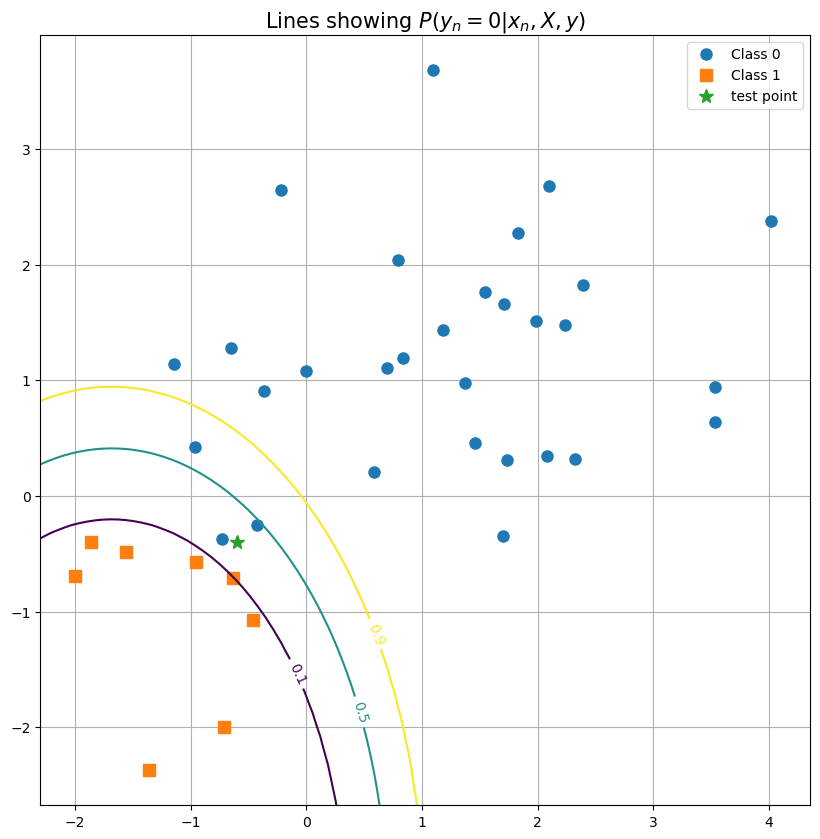

In [11]:
# Define and train the model
model = GaussianNaiveBayes()
model.fit(X_train, y_train)

# Prediction
y_pred_train, _ = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test,y_pred_prob_test = model.predict(X_test)
print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, y_pred_prob_test[0,y_pred_test]))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Lines showing $P(y_{n} = 0 | x_{n}, X, y)$')
fig, ax = decision_boundary(model, fig, ax, labels = True)

## Support Vector Machines (SVM)

In [12]:
class SVM():
    """
    Custom implementation of linear SVM.
    """
    def __init__(self, learning_rate, n_iterations, C = 1, print_cost=False):
        """
        Parameter(s):
            learning_rate - Learning rate
            n_iterations  - Number of iterations
            C             - Regularization parameter
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.C = C
        self.print_cost = print_cost
        self.parameters = {}

    def initialize_parameters(self, n_features):
        """
        Initialize model parameters with zeros:
            w.shape = (n_features, 1)
            b.shape = (1,)
        --------------------
        Input(s):
            n_features - Number of features
        --------------------
        Output(s):
        """

        w = np.zeros(shape = (n_features,1))
        b = 0
        self.parameters["w"] = w
        self.parameters["b"] = b


    def grad_cost(self, X_train, t, w, b):
        """
        Computes the cost function (hinge loss) and
        partial derivatives of cost w.r.t the model parameters.
        --------------------
        Input(s):
            X_train - Data of size(n_samples, n_features)
            t       - Labels (-1 or 1) of size (n_samples,)
            w,b     - Model parameters
        --------------------
        Output(s):
            cost  - hinge loss
            grads - Gradients of loss function w.r.t model parameters (dw,db).
        """
        n_samples = X_train.shape[0]
        t = t.reshape(-1,1)
        p = np.dot(X_train, w) + b
        margin = 1 - t * p
        loss = np.maximum(0,margin)    #hinge loss
        sumLoss = np.sum(loss)/n_samples
        cost = (1/2) * np.dot(w.T, w) + self.C * sumLoss

        indicator = (margin > 0).astype(int) 
        dw = w - (self.C / n_samples) * np.dot(X_train.T, t * (1 - indicator))
        db = - (self.C / n_samples) * np.sum(t * (1 - indicator))

        grads = {"dw": dw, "db": db}
        return cost, grads

    def fit(self, X_train, y_train):
        """
        Optimize model parameters by running a gradient descent algorithm.
        --------------------
        Input(s):
            X_train - Data of size (n_samples, n_features)
            y_train - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """
        n_features = X_train.shape[1]
        # Change the binary targets from (0,1) to (-1,1)
        t = np.where(y_train < 0.5, -1, 1)
        self.initialize_parameters(n_features)

        # Gradient descent
        w = self.parameters["w"]
        b = self.parameters["b"]
        for i in range(1,self.n_iterations+1):
            cost, grads = self.grad_cost(X_train, t, w, b)
            dw = grads["dw"]
            db = grads["db"]

            w -= self.learning_rate * dw
            b -= self.learning_rate * db

            if self.print_cost and i % 100 == 0:
                print(f"Cost after iteration {i}: {cost.item()}")  #scalar cost

        self.parameters["w"] = w
        self.parameters["b"] = b
        return self
    
    def predict(self, X_test):
        """
        Binary prediction of test data.
        --------------------
        Input(s):
            X   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels (0/1) of size (n_samples,1)
        """

        w = self.parameters["w"]
        b = self.parameters["b"]
        decision = np.dot(X_test, w) + b
        y_pred = np.sign(decision)
        y_pred[decision == 0] = 1  # decision is exactly 0
        y_pred = ((y_pred + 1) // 2).astype(np.int32)
        return y_pred.squeeze()

In [13]:
class SVM():
    def __init__(self, learning_rate, n_iterations, C = 1, print_cost=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.C = C
        self.print_cost = print_cost
        self.parameters = {}

    def initialize_parameters(self, n_features):
        w = np.zeros(shape = (n_features,1))
        b = 0
        self.parameters["w"] = w
        self.parameters["b"] = b
        
    def grad_cost(self, X_train, t, w, b):
        n_samples = X_train.shape[0]
        t = t.reshape(-1,1)
        p = np.dot(X_train, w) + b
        margin = 1 - t * p
        loss = np.maximum(0, margin)  # hinge loss
        sumLoss = np.sum(loss) / n_samples
        cost = 0.5 * np.dot(w.T, w) + self.C * sumLoss
    
        indicator = (margin > 0).astype(int)
        dw = w - (self.C / n_samples) * np.dot(X_train.T, (indicator * t))
        db = - (self.C / n_samples) * np.sum(indicator * t)
        grads = {"dw": dw, "db": db}
        return cost.squeeze(), grads  # ensure cost is a scalar

    def fit(self, X_train, y_train):
        n_features = X_train.shape[1]
        t = np.where(y_train < 0.5, -1, 1)
        self.initialize_parameters(n_features)
        w = self.parameters["w"]
        b = self.parameters["b"]
        for i in range(1,self.n_iterations+1):
            cost, grads = self.grad_cost(X_train, t, w, b)
            dw = grads["dw"]
            db = grads["db"]
            w -= self.learning_rate * dw
            b -= self.learning_rate * db
            if self.print_cost and i % 100 == 0:
                print(f"Cost after iteration {i}: {cost}")

        self.parameters["w"] = w
        self.parameters["b"] = b
        return self
    
    def predict(self, X_test):
        w = self.parameters["w"]
        b = self.parameters["b"]
        decision = np.dot(X_test, w) + b
        y_pred = np.where(decision >= 0, 1, 0)  # if decision is >= 0, classify as 1, else 0
        return y_pred.squeeze()

Cost after iteration 100: 0.38238630184974015
Cost after iteration 200: 0.3709795958672184
Cost after iteration 300: 0.3658345726992506
Cost after iteration 400: 0.36281047321162313
Cost after iteration 500: 0.36107543503257256
Cost after iteration 600: 0.36010385553090085
Cost after iteration 700: 0.3593726907253024
Cost after iteration 800: 0.3586749924351077
Cost after iteration 900: 0.35798177797776565
Cost after iteration 1000: 0.35741516291784986
Train accuracy: 84.211 %
Predicted test class: 0


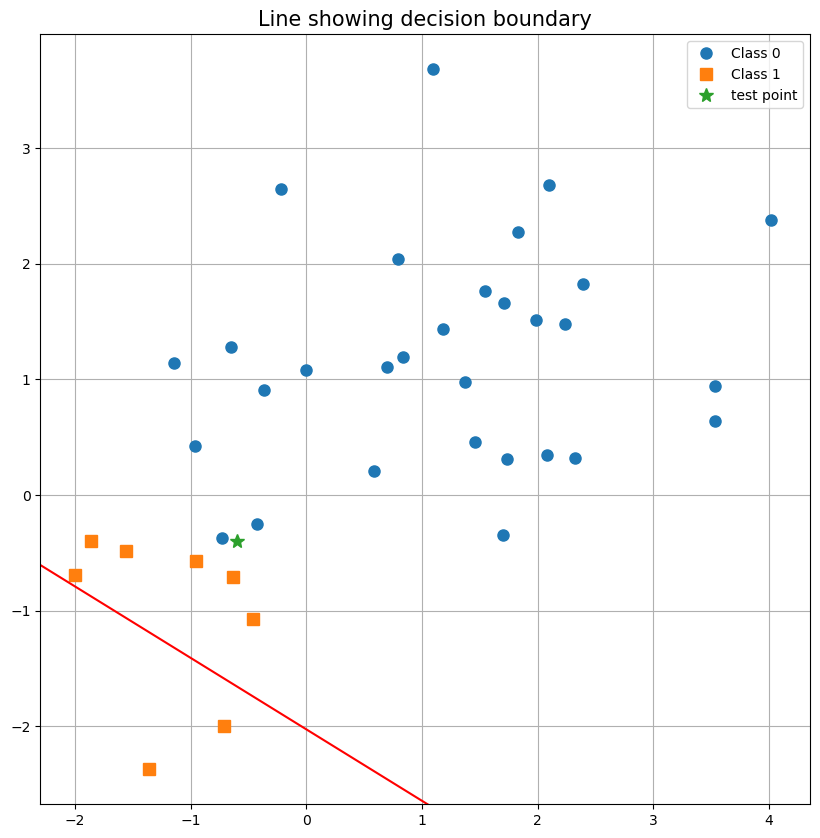

In [14]:
# Parameters (feel free to change)
learning_rate = 0.01
n_iterations = 1000
C = 1
print_cost = True

# Define and train the model
model = SVM(learning_rate, n_iterations, C, print_cost)
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test = model.predict(X_test)
print("Predicted test class: %d" %(y_pred_test))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Line showing decision boundary')
w = model.parameters['w'].flatten() #1D array for proper unpacking
b = model.parameters['b'].item()
epsilon = 1e-10   #avoid division by 0
x = np.linspace(-3, 3, 200)
ax.plot(x, (-b - w[0] * x) / (w[1] + epsilon), '-r')

## Logistic Regression

In [15]:
class LogisticRegression():
    """
    Custom implementation of (binary) Logistic Regression.
    """
    def __init__(self, learning_rate, n_iterations, print_cost=False):
        """
        Parameter(s):
            learning_rate - Learning rate
            n_iterations  - Number of iterations
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.print_cost = print_cost
        self.parameters = {}

    def initialize_parameters(self, n_features):
        """
        Initialize model parameters with zeros:
            w.shape = (n_features,)
            b.shape = (1,)
        --------------------
        Input(s):
            n_features - Number of features
        --------------------
        Output(s):
        """
        w = np.zeros(shape = (n_features,1))
        b = 0
        self.parameters['w'] = w
        self.parameters['b'] = b

    def sigmoid(self, z):
        """
        Sigmoid function
        --------------------
        Input(s):
            z -
        --------------------
        Output(s):
            s - sigmoid(z)
        """
        s = 1 / (1 + np.exp(-z))
        return s

    def grad_cost(self, X_train, y_train, w, b):
        """
        Computes the cost function (negative log-likelihood) and
        partial derivatives of cost w.r.t the model parameters.
        --------------------
        Input(s):
            X_train - Data of size(n_samples, n_features)
            y_train - True labels of size (n_samples,1)
            w,b     - Model parameters
        --------------------
        Output(s):
            cost  - Negative log-likelihood cost
            grads - Gradients of loss function w.r.t model parameters (dw,db).
        """
        n_samples = X_train.shape[0]
        y_train = y_train.reshape(-1,1)
        A = self.sigmoid(np.dot(X_train, w) + b) # activation
        cost = -np.mean(y_train * np.log(A) + (1 - y_train) * np.log(1 - A))  #cost- negative log-likelihood
        dw = (1 / n_samples) * np.dot(X_train.T, (A - y_train))
        db = (1 / n_samples) * np.sum(A - y_train)
        grads = {"dw": dw, "db": db}
        return cost, grads

    def fit(self, X_train, y_train):
        """
        Optimize model parameters by running a gradient descent algorithm.
        --------------------
        Input(s):
            X_train - Data of size (n_samples, n_features)
            y_train - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """
        n_features = X_train.shape[1]
        self.params = self.initialize_parameters(n_features)

        # Gradient descent
        w = self.parameters["w"]
        b = self.parameters["b"]
        for i in range(1,self.n_iterations+1):
            cost, grads = self.grad_cost(X_train, y_train, w, b)
            dw = grads["dw"]
            db = grads["db"]
            w -= self.learning_rate * dw
            b -= self.learning_rate * db
            if self.print_cost and i % 100 == 0:
                print("Cost after iteration %i: %f" %(i, cost))
        self.parameters = {"w": w, "b": b}
        return self

    def predict(self, X_test):
        """
        Binary prediction of test data.
        --------------------
        Input(s):
            X   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels (0/1) of size (n_samples,)
        """
        w = self.parameters["w"]
        b = self.parameters["b"]
        n_samples = X_test.shape[0]
        y_pred = np.zeros((n_samples,1))
        A = self.sigmoid(np.dot(X_test, w) + b)
        # A = np.zeros((n_samples,1))
        y_pred = (A > 0.5).astype(int)
        return y_pred.squeeze(), A

Cost after iteration 100: 0.180875
Cost after iteration 200: 0.138702
Cost after iteration 300: 0.119734
Cost after iteration 400: 0.108276
Cost after iteration 500: 0.100370
Cost after iteration 600: 0.094472
Cost after iteration 700: 0.089841
Cost after iteration 800: 0.086068
Cost after iteration 900: 0.082909
Cost after iteration 1000: 0.080206
Train accuracy: 97.368 %
Predicted test class: 1, (prob 0.56)


C:\Users\omkarp\AppData\Local\Temp\ipykernel_5948\2738607731.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, np.where(y_pred_prob_test < 0.5, 1-y_pred_prob_test, y_pred_prob_test)))


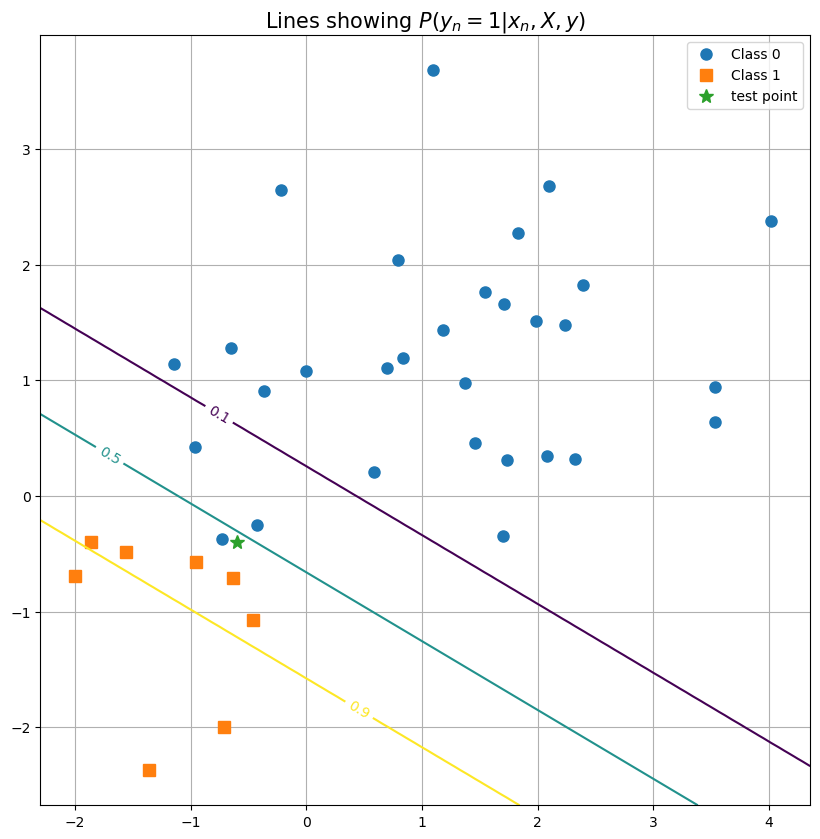

In [16]:
# Parameters (feel free to change)
learning_rate = 0.05
n_iterations = 1000
print_cost = True

# Define and train the model
model = LogisticRegression(learning_rate, n_iterations, print_cost)
model.fit(X_train, y_train)

# Predictions
y_pred_train, _ = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test,y_pred_prob_test = model.predict(X_test)
print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, np.where(y_pred_prob_test < 0.5, 1-y_pred_prob_test, y_pred_prob_test)))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Lines showing $P(y_{n} = 1 | x_{n}, X, y)$')
fig, ax = decision_boundary(model, fig, ax, labels = True)

# Comparisons

In [17]:
# Load the breast cancer dataset
X, y = load_breast_cancer(return_X_y=True)
X = X[:,:10] # Only looking at the first 10 features (the mean values)
X = StandardScaler().fit_transform(X)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=0)

print('Training set:\t', X_train_new.shape,  y_train_new.shape)
print('Test set:\t', X_test_new.shape,  y_test_new.shape)

Training set:	 (455, 10) (455,)
Test set:	 (114, 10) (114,)


In [18]:
# Parameters (feel free to change)
learning_rate = 0.05
n_iterations = 1000
C = 10
print_cost = False
K = 5

# Define all models
models = {"KNN":K_Nearest_Neighbors(n_neighbors = K),
          "SVM":SVM(learning_rate, n_iterations, C, print_cost),
          "LR":LogisticRegression(learning_rate, n_iterations, print_cost),
          "GNB":GaussianNaiveBayes()}

# Train all models and report performance
for name, model in models.items():
    print(name)
    model.fit(X_train_new, y_train_new)
    if name == "SVM":
        y_pred_train = model.predict(X_train_new)
        y_pred_test = model.predict(X_test_new)
    else:
        y_pred_train,_ = model.predict(X_train_new)
        y_pred_test,_ = model.predict(X_test_new)
    print("\tTrain accuracy: %.3f %%" %(np.mean(y_pred_train == y_train_new)*100))
    print("\tTest accuracy: %.3f %%" %(np.mean(y_pred_test == y_test_new)*100))

KNN
	Train accuracy: 96.484 %
	Test accuracy: 91.228 %
SVM
	Train accuracy: 93.846 %
	Test accuracy: 94.737 %
LR
	Train accuracy: 94.725 %
	Test accuracy: 93.860 %
GNB
	Train accuracy: 92.088 %
	Test accuracy: 88.596 %


**Conclude:** Although KNN has the best fit, it would indicate overfitting- as test accuracy is lower- indicated need for a larger dataset. SVM has a good test accuracy/generalisation, its sensitive to kernel and C param configuration.
LR has concerns for non-linear decision boundaries for our data. GNB eventhough has the lowest accuracy, (which might be due to feature dependence) its probabilistic output makes it valuable in terms of interpretability.